In [4]:
from langgraph.graph import StateGraph, START, END, add_messages
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain_community.tools import TavilySearchResults
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

memory = MemorySaver()

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatGroq(model="llama-3.1-8b-instant")
llm_with_tools = llm.bind_tools(tools=tools)

class BasicState(TypedDict): 
    messages: Annotated[List, add_messages]

def model(state: BasicState): 
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

def tools_router(state: BasicState): 
    last_message = state["messages"][-1]
    if(hasattr(last_message, "tool_calls") and 
    len(last_message.tool_calls) > 0):
        return "tools"
    else: 
        return END


graph = StateGraph(BasicState)
graph.add_node(model, "model")
graph.add_node("tools", ToolNode(tools=tools))

graph.set_entry_point("model")
graph.add_conditional_edges("model", tools_router)

graph.add_edge("tools", "model")

app = graph.compile(checkpointer=memory, interrupt_before=["tools"])

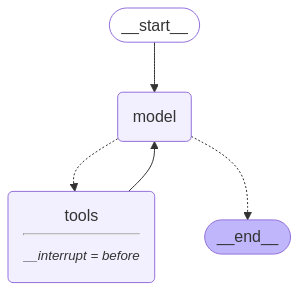

In [5]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [6]:

config = {"configurable": {
    "thread_id": 1
}}

events = app.stream({
    "messages": [HumanMessage(content="What is the current weather in Chennai?")]
}, config=config, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the current weather in Chennai?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_bvqn)
 Call ID: call_bvqn
  Args:
    query: Chennai current weather


In [7]:
snapshot = app.get_state(config=config)
snapshot.next

('tools',)

In [8]:
events = app.stream(None, config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_bvqn)
 Call ID: call_bvqn
  Args:
    query: Chennai current weather
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://timesofindia.indiatimes.com/weather/chennai-weather-forecast-today/600017", "content": "Today's Weather in Chennai: In Chennai today, the weather is expected to be Haze with a maximum temperature of 33°C and a minimum of 26°C. Sunrise in"}, {"url": "https://www.indiatoday.in/weather/chennai-weather-forecast-today", "content": "The minimum temperature in Chennai today is likely to hover around 26 degrees Celsius, while the maximum temperature might reach 31 degrees Celsius."}]
================================== Ai Message ==================================

Based on the search results, the current weather in Chennai is expected to be Haze with a maximum temperatu